In [1]:
vaultType = 'scaled'
V_Prefix = '[VAULT 4]'
vaultName = 'vault4'

## ROC Functions 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
# import os

from ipywidgets import IntProgress
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({'font.size': 12})

from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import CubicSpline



#Data Type for ROC graphs (Data name, False Positives, True Positives, False Negatives, True Negatives)
def ROC_DATA(label, FP='-', TP='-', FN='-', TN='-', THRESHOLD='-'):
    obj = {'Label':label }
    if(not(FP is '-')):
        obj['FP'] = FP
    if(not(FN is '-')):
        obj['FN'] = FN
    if(not(TP is '-')):
        obj['TP'] = TP
    if(not(TN is '-')):
        obj['TN'] = TN
    if(not(THRESHOLD is '-')):
        obj['THRESHOLD'] = THRESHOLD
    return obj



#makes ROC_DATA for a all columns in a df
def getRate(df, col, label='Default'):
    FP, TP = [], []
    FN, TN = [], []
    THRESHOLD = []
    for i in range(0, 100):
        threshold=i/100.
        THRESHOLD.append(threshold)
        FP.append(len(df[(df[col]<threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
        TP.append(len(df[(df[col]<threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        FN.append(len(df[(df[col]>threshold) & (df['Success']==0)])/len(df[df['Success']==0]))
        TN.append(len(df[(df[col]>threshold) & (df['Success']==1)])/len(df[df['Success']==1]))
    return ROC_DATA(label, TP=TP, FP=FP, TN=TN, FN=FN, THRESHOLD=THRESHOLD)
    
#Limits columns in a DF to  particular value
def limitVal(df, ignore = ['Success'], N = np.finfo(np.float32).max):
    for c in df.drop(columns=ignore).columns:
#         df[c].loc[df[c] >= N] = N
#         print(df[c].dtype)
        if(not (df[c].dtype == 'bool')):
            df[c] = df[c].where(df[c] <= 1., 1.) 
    return df


#Takes the average of all columns in a df
def avgVal(df, colName = "AvgPred", JUST_PREDS=False, verbose=False):
    ignore = []
    if('Success' in df.columns):
        ignore.append('Success')
    if(JUST_PREDS):
        for col in df.columns:
            if(not(col[:4]=='Pred')):
#                 print(col)
                ignore.append(col)
            elif(verbose):
                print(col)
    df[colName] = df.drop(columns=ignore).mean(axis=1)
    return df


In [4]:
#Plot an array of ROC_DATA
def plotRocs(rocObjArray):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    ax = fig.add_subplot(1,1,1)
    for rocData in rocObjArray:
        d = rocData
        label = d['Label']
        FP, TP = d['FP'], d['TP']
        ax.plot(FP,TP,'-', lw=3,label = label, zorder = -32, alpha=.5)
    handles, labels = ax.get_legend_handles_labels()
    display = (0,71)
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim(0,1)
    ax.set_ylabel('True Positive Rate')
    ax.set_ylim(0,1)
    ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)
    ax.set_title(V_Prefix + ' ROC Curve Comparison')
    ax.legend()

In [5]:
from colour import Color
red = Color("red")
colormap = list(red.range_to(Color("green"),100))
def mapToColors(values):
    colors = []
    for v in values:
        i = int(v*100)
        colors.append(str(colormap[i]))
    return colors

In [6]:
#Plot a single ROC_DATA with THRESHOLD as a second x-axis
def plotColorRoc(rocData, vault=V_Prefix):
    # plot it
    fig = plt.figure(figsize=(6, 5)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[5, .25]) 

    ax0 = plt.subplot(gs[0])
    d = rocData
    label = d['Label']
    
    FP, TP = d['FP'], d['TP']
    THRESHOLD = d['THRESHOLD']
    COLORS = mapToColors(THRESHOLD)
    for i in range(1, len(FP)):
        ax0.plot((FP[i-1], FP[i]),(TP[i-1], TP[i]), c = COLORS[i], label = "FP", lw=3.)
        
    ax0.set_xlabel('False Positive Rate')
    ax0.set_xlim(0,1)
    ax0.set_ylabel('True Positive Rate')
    ax0.set_ylim(0,1)
    ax0.set_title(vault + " ["+ label+ "]")
    ax0.grid(color='black', linestyle='-', linewidth=1, alpha=.5)


    ax1 = plt.subplot(gs[1])
    ax1.yaxis.tick_right()
    ax1.set_xlim(0,1)
    ax1.get_xaxis().set_visible(False)
    ax1.set_ylabel('Threshold')
    ax1.set_ylim(0,1)

    values = np.arange(0., 1., .01)
    for i in range(0, 100):
        plt.plot((0, 1.), (values[i], values[i]), c = str(colormap[i]), lw=4)

## Forest Functions

In [7]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Samples DF for an approximate numnber of rows  (Needed for balanceDF)
def cutDF(df, intendedNumber):
    df = df.sample(frac=intendedNumber/len(df), replace=True)
    return df

#Returns DF with 50/50 split on specified binary column
def balanceDF(df, colName, numberOfEach = 0):
    failDF = df[df[colName]==False]
    successDF = df[df[colName]==True]
    if(numberOfEach == 0):
        maxContestsForBalance = min(len(successDF), len(failDF))
        numberOfEach = int(maxContestsForBalance*.1)
    combinedDF = pd.concat([cutDF(successDF, numberOfEach), cutDF(failDF, numberOfEach)])
    return combinedDF

#Splits a df into two parts, for testing and training
def splitTrainingTesting(df, percentTrain, TYPE='None', basedOnVault=False):
    if(not basedOnVault):
        df = df.copy(deep=True)
        if(TYPE=="CLF"):
            df['Success'] = df['Success'].astype('int')
        elif(TYPE=='REGR'):
            df['Success'] = df['Success'].astype('float')
        df['is_train'] = np.random.uniform(0, 1, len(df)) <= percentTrain
        trainDF, testDF = df[df['is_train']==True], df[df['is_train']==False]
        df = df.drop(columns=['is_train'], axis=1)
        trainDF = trainDF.drop(['is_train'], axis=1)
        testDF = testDF.drop(['is_train'], axis=1)
        return trainDF, testDF
    else:
        nonVault = pd.merge(nonVaultDF, df, on='ContestId', how='left')
        vault = df[~df.index.isin(nonVault.index)].dropna()
#         return len(vault), len(nonVault)
        numTrain = len(nonVault)
        numTest = int((1-percentTrain)*numTrain)
        vault.sample(n=numTest, random_state=1)
        return nonVault, vault.sample(n=numTest, random_state=1)


#Simple wrapper for a making a classifier
def classifierWrapper(trainDF, classifierType, balanced=True):
    trainDF = trainDF.copy(deep=True)
    if(balanced):
        trainDF = balanceDF(trainDF, 'Success')
    clf = makeAndTrainCLF(trainDF, classifierType)
    columns = trainDF.columns.drop('Success')
    return {"clf":clf, "cols":columns}

#Trains a classifier of the provided 
def makeAndTrainCLF(trainDF, classifierType, successCol = 'Success'): ####################
    clf = classifierType()
    clf.fit(trainDF[trainDF.columns.drop(successCol)], trainDF[successCol].astype('int'))
    return clf


def EnsembleWithMinAcc(trainDF, classifierType, balanced=True, numCLF = 20, accuracy=0.):
    CLFS = []
    for i in range(0, numCLF):
        currAcc = -1.
        while(currAcc < accuracy):
            clf = classifierWrapper(trainDF, RandomForestClassifier, balanced=balanced)
            currAcc = accuracy_score(clf['clf'].predict(trainDF[clf['cols']]), trainDF['Success'])
        CLFS.append(clf)
    return CLFS

def getEnsPred(testDF, CLFS):
    rDF = testDF[['Success']].copy(deep=True)
    count = 0
    for CLF in CLFS:
        count+=1
        classifier, columns = CLF['clf'], CLF['cols']
        rDF['CLF'+str(count)] = classifier.predict(testDF[columns])
    return rDF

In [8]:
def filterColumns(columns, contains):
    return list(filter(lambda x : contains in x, list(columns)))

### Data Files for ROC

In [9]:
fullContests = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [10]:
# Percent Full at 4 hours out
baselineDF = pd.read_csv('data/baseline.csv').drop(columns=['Unnamed: 0'])

# Meta Data file
metaDataDF = pd.read_csv('data/MetaData.csv')

# Kalman Filter
# kfResultsDF = pd.read_csv('data/'+vaultType+'/KF_Results.csv')
kfResultsDF = pd.read_csv('data/'+vaultType+'/KF_Results.csv')

# Linear Regression
# lrResultsDF = pd.read_csv('data/'+vaultType+'/LR_Results.csv')
lrResultsDF = pd.read_csv('data/'+vaultType+'/LR_Results.csv')

In [11]:
trainDF = pd.read_csv("dataVault/train.csv").set_index('ContestId')
trainDF = trainDF.reset_index().drop_duplicates(subset='ContestId').set_index('ContestId')
testDF = pd.read_csv("dataVault/"+vaultName+".csv").set_index('ContestId')
testDF = testDF.reset_index().drop_duplicates(subset='ContestId').set_index('ContestId')

print("Number of contests in trainDF:",len(trainDF))
print("Number of contests in testDF:",len(testDF))

Number of contests in trainDF: 373711
Number of contests in testDF: 64473


In [12]:
tooShortDF = pd.read_csv('data/'+vaultType+'/LR_Results.csv').set_index('ContestId')
tooShortDF = avgVal(tooShortDF, JUST_PREDS=True)
tooShortIds = tooShortDF[tooShortDF['AvgPred']==0].index

In [13]:
tooShortDF2 = pd.read_csv('data/'+vaultType+'/KF_Results.csv').set_index('ContestId')
tooShortDF2 = avgVal(tooShortDF2, JUST_PREDS=True)
tooShortIds = set(list(tooShortIds) + list(tooShortDF[tooShortDF['AvgPred']==0].index))

In [14]:
trainDF2 = trainDF[~trainDF.index.isin(tooShortIds)]
testDF2 = testDF[~testDF.index.isin(tooShortIds)]

### Calculating ROC_DATA

Baseline ROC Generation

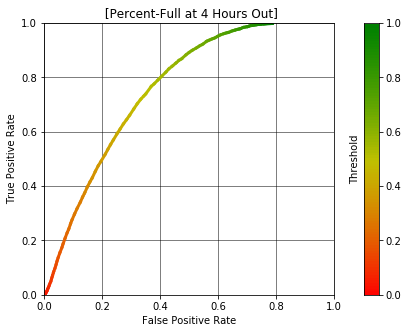

In [15]:
# print("... Calculating Baseline 4-hours-out Prediction")
baselineRates = getRate(baselineDF, 'FourHoursOut_Scaled', label='Percent-Full at 4 Hours Out')
plotColorRoc(baselineRates, vault="")

Meta Data ROC Generation

In [16]:
metaColumns = list(metaDataDF.columns.drop('ContestId'))
metaColumns.append('Success')
metaTrain, metaTest = trainDF[metaColumns], testDF[metaColumns]

In [17]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)
metaPreds = avgVal(getEnsPred(limitVal(metaTest), metaCLFS))

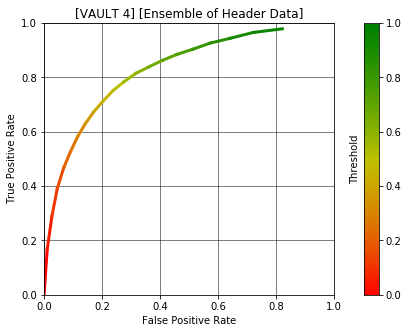

In [18]:
metaEnsembleRates =  getRate(metaPreds, 'AvgPred', label='Ensemble of Header Data')
plotColorRoc(metaEnsembleRates)

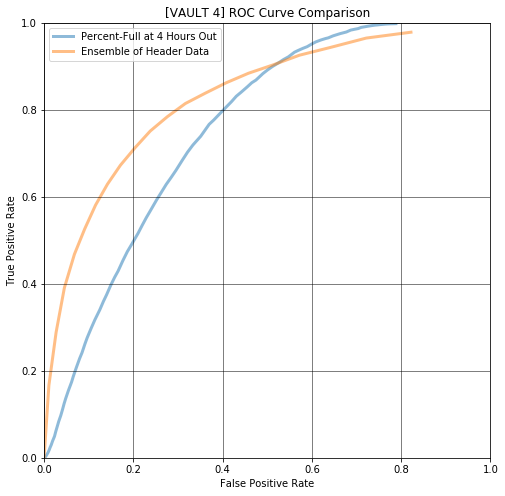

In [19]:
plotRocs([baselineRates, metaEnsembleRates])

Kalman Filter ROC Generation

In [20]:
kfColumns = list(kfResultsDF.columns.drop('ContestId'))
kfColumns.append('Success')
kfTrain, kfTest = trainDF[kfColumns], testDF[kfColumns]

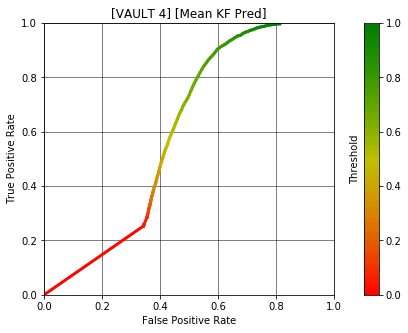

In [21]:
kfTestAvg = avgVal(limitVal(kfTest, N=1.), JUST_PREDS=True)
kfAvgRate = getRate(kfTestAvg, 'AvgPred', label='Mean KF Pred')
plotColorRoc(kfAvgRate)

In [22]:
kfTrain2, kfTest2 = trainDF2[kfColumns], testDF2[kfColumns]

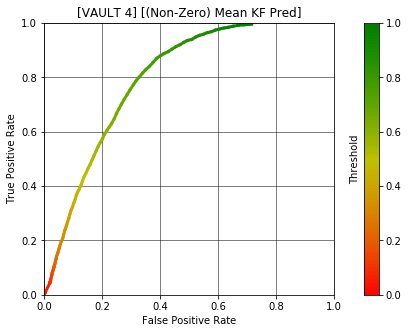

In [23]:
kfTestAvg2 = avgVal(limitVal(kfTest2, N=1.), JUST_PREDS=True)
kfAvgRate2 = getRate(kfTestAvg2, 'AvgPred', label='(Non-Zero) Mean KF Pred')
plotColorRoc(kfAvgRate2)

Linear Regression ROC Generation

In [24]:
lrColumns = list(lrResultsDF.columns.drop('ContestId'))
lrColumns.append('Success')
lrTrain, lrTest = trainDF[lrColumns], testDF[lrColumns]

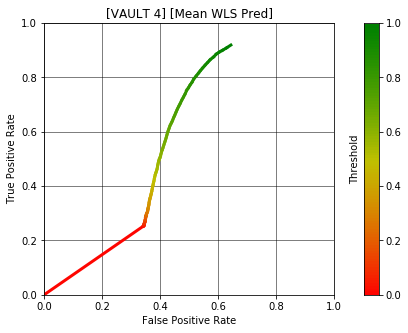

In [25]:
lrTestAvg = avgVal(limitVal(lrTest, N=1.), JUST_PREDS=True)
lrAvgRate = getRate(lrTestAvg, 'AvgPred', label='Mean WLS Pred')
plotColorRoc(lrAvgRate)

In [26]:
lrTrain2, lrTest2 = trainDF2[lrColumns], testDF2[lrColumns]

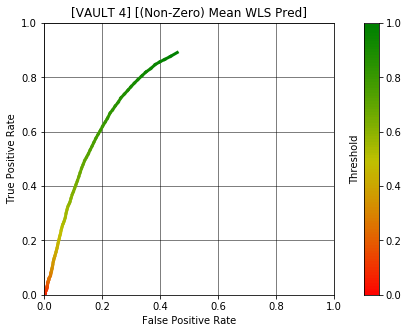

In [27]:
lrTestAvg2 = avgVal(limitVal(lrTest2, N=1.), JUST_PREDS=True)
lrAvgRate2 = getRate(lrTestAvg2, 'AvgPred', label='(Non-Zero) Mean WLS Pred')
plotColorRoc(lrAvgRate2)

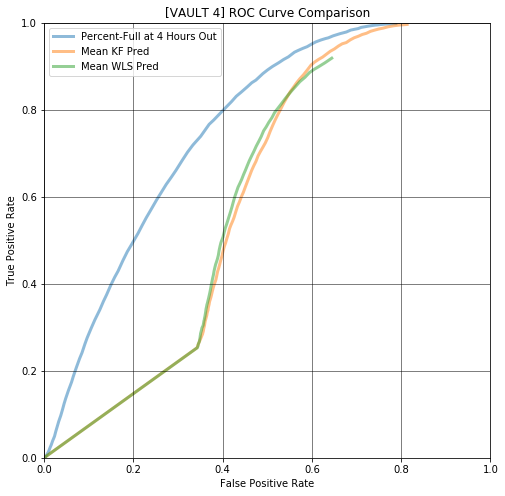

In [28]:
plotRocs([baselineRates, kfAvgRate, lrAvgRate])

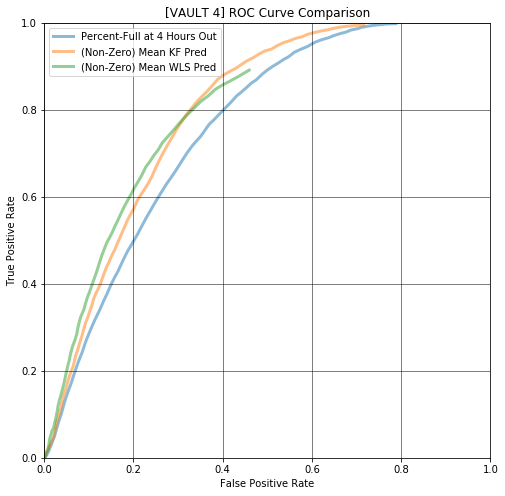

In [29]:
plotRocs([baselineRates, kfAvgRate2, lrAvgRate2])

AVG LR + KF

In [30]:
cColumns = list(lrResultsDF.columns.drop('ContestId')) + list(kfResultsDF.columns.drop('ContestId'))
cColumns.append('Success')
cTrain, cTest = trainDF[cColumns], testDF[cColumns]

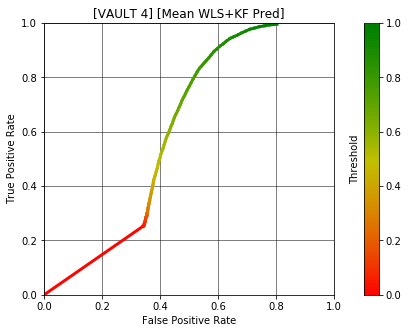

In [31]:
cTestAvg = avgVal(limitVal(cTest, N=1.), JUST_PREDS=True)
cAvgRate = getRate(cTestAvg, 'AvgPred', label='Mean WLS+KF Pred')
plotColorRoc(cAvgRate)

In [32]:
cTrain2, cTest2 = trainDF2[cColumns], testDF2[cColumns]

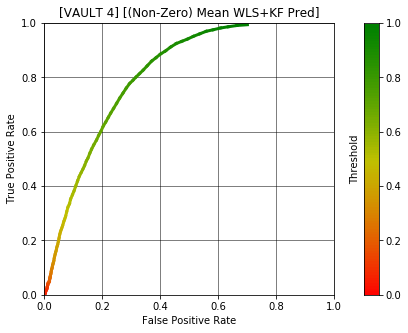

In [33]:
cTestAvg2 = avgVal(limitVal(cTest2, N=1.), JUST_PREDS=True)
cAvgRate2 = getRate(cTestAvg2, 'AvgPred', label='(Non-Zero) Mean WLS+KF Pred')
plotColorRoc(cAvgRate2)

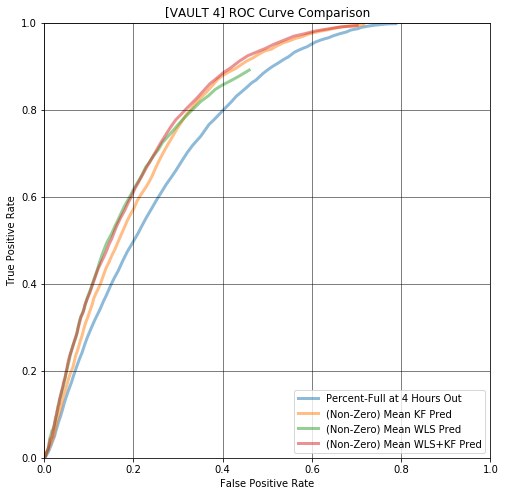

In [34]:
plotRocs([baselineRates, kfAvgRate2, lrAvgRate2, cAvgRate2])

### LR/KF Ensembles

In [35]:
kfCLFS = EnsembleWithMinAcc(limitVal(kfTrain), RandomForestClassifier, accuracy = .6)
kfPreds = avgVal(getEnsPred(limitVal(kfTest), kfCLFS))

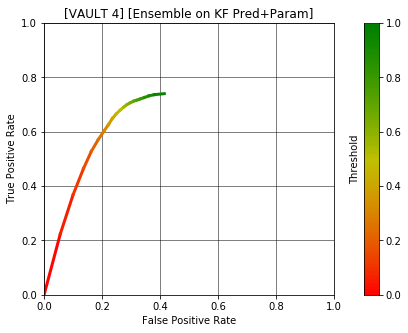

In [36]:
kfEnsembleRates =  getRate(kfPreds, 'AvgPred', label='Ensemble on KF Pred+Param')
plotColorRoc(kfEnsembleRates)

In [37]:
kfCLFS2 = EnsembleWithMinAcc(limitVal(kfTrain2), RandomForestClassifier, accuracy = .6)
kfPreds2 = avgVal(getEnsPred(limitVal(kfTest2), kfCLFS2))

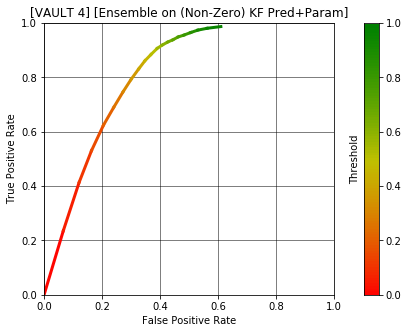

In [38]:
kfEnsembleRates2 =  getRate(kfPreds2, 'AvgPred', label='Ensemble on (Non-Zero) KF Pred+Param')
plotColorRoc(kfEnsembleRates2)

In [39]:
lrCLFS = EnsembleWithMinAcc(limitVal(lrTrain), RandomForestClassifier, accuracy = .6)
lrPreds = avgVal(getEnsPred(limitVal(lrTest), lrCLFS))

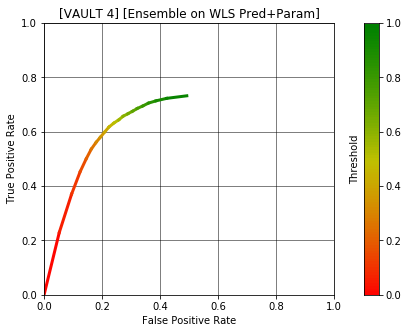

In [40]:
lrEnsembleRates =  getRate(lrPreds, 'AvgPred', label='Ensemble on WLS Pred+Param')
plotColorRoc(lrEnsembleRates)

In [41]:
lrCLFS2 = EnsembleWithMinAcc(limitVal(lrTrain2), RandomForestClassifier, accuracy = .5)
lrPreds2 = avgVal(getEnsPred(limitVal(lrTest2), lrCLFS2))

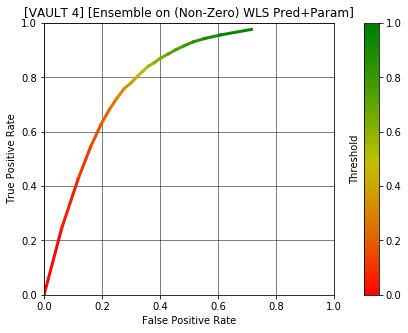

In [42]:
lrEnsembleRates2 =  getRate(lrPreds2, 'AvgPred', label='Ensemble on (Non-Zero) WLS Pred+Param')
plotColorRoc(lrEnsembleRates2)

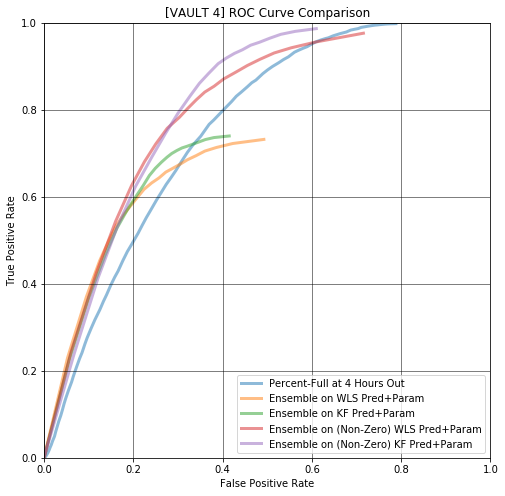

In [43]:
plotRocs([baselineRates, lrEnsembleRates, kfEnsembleRates, lrEnsembleRates2, kfEnsembleRates2])

### Merging Predictors

In [44]:
cColumns = list(set(kfColumns+lrColumns))
cTrain, cTest = trainDF[cColumns], testDF[cColumns]

In [45]:
cCLFS = EnsembleWithMinAcc(limitVal(cTrain), RandomForestClassifier, accuracy = .6)
cPreds = avgVal(getEnsPred(limitVal(cTest), cCLFS))

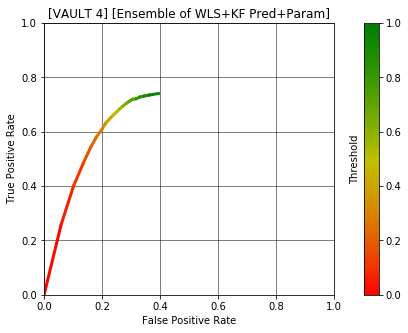

In [46]:
cEnsembleRates =  getRate(cPreds, 'AvgPred', label='Ensemble of WLS+KF Pred+Param')
plotColorRoc(cEnsembleRates)

In [47]:
cTrain2, cTest2 = trainDF2[cColumns], testDF2[cColumns]

In [48]:
cCLFS2 = EnsembleWithMinAcc(limitVal(cTrain2), RandomForestClassifier, accuracy = .6)
cPreds2 = avgVal(getEnsPred(limitVal(cTest2), cCLFS2))

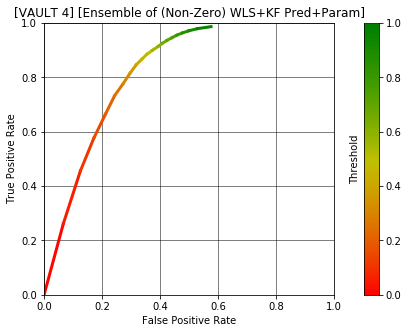

In [49]:
cEnsembleRates2 =  getRate(cPreds2, 'AvgPred', label='Ensemble of (Non-Zero) WLS+KF Pred+Param')
plotColorRoc(cEnsembleRates2)

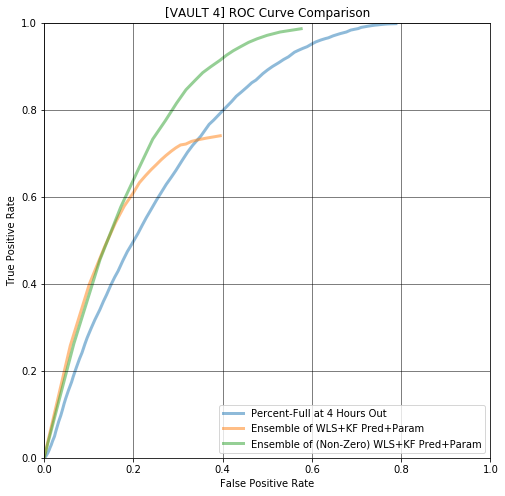

In [50]:
plotRocs([baselineRates, cEnsembleRates, cEnsembleRates2])

### Adding Meta Data

In [51]:
fullColumns = list(set(metaColumns+lrColumns+kfColumns))
fullTrain, fullTest = trainDF[fullColumns], testDF[fullColumns]
fullTrain2, fullTest2 = trainDF2[fullColumns], testDF2[fullColumns]

In [52]:
fullCLFS = EnsembleWithMinAcc(limitVal(fullTrain), RandomForestClassifier, accuracy = .6)
fullPreds = avgVal(getEnsPred(limitVal(fullTest), fullCLFS))

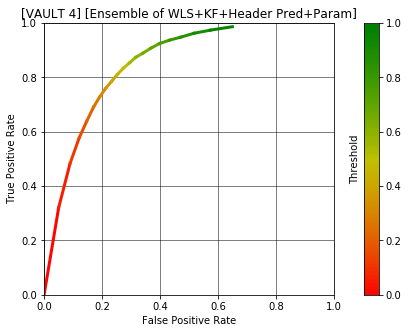

In [53]:
fullEnsembleRates =  getRate(fullPreds, 'AvgPred', label='Ensemble of WLS+KF+Header Pred+Param')
plotColorRoc(fullEnsembleRates)

In [54]:
fullCLFS2 = EnsembleWithMinAcc(limitVal(fullTrain2), RandomForestClassifier, accuracy = .6)
fullPreds2 = avgVal(getEnsPred(limitVal(fullTest2), fullCLFS2))

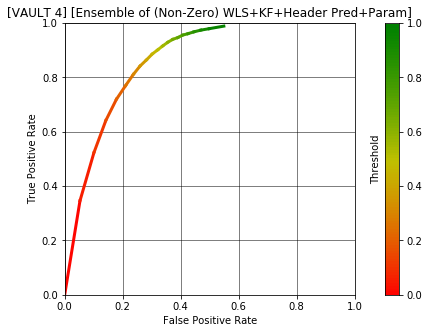

In [55]:
fullEnsembleRates2 =  getRate(fullPreds2, 'AvgPred', label='Ensemble of (Non-Zero) WLS+KF+Header Pred+Param')
plotColorRoc(fullEnsembleRates2)

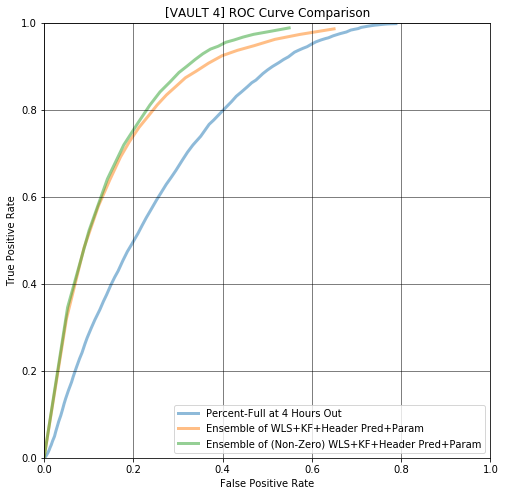

In [56]:
plotRocs([baselineRates, fullEnsembleRates, fullEnsembleRates2])

### Pacer Data

In [57]:
pacerData = pd.read_csv('data/DK_Pacer_Success.csv').set_index('ContestId')

In [58]:
pacerRate = getRate(limitVal(pacerData, N=1.), 'PacerSuccess', label='Pacer Prediction')

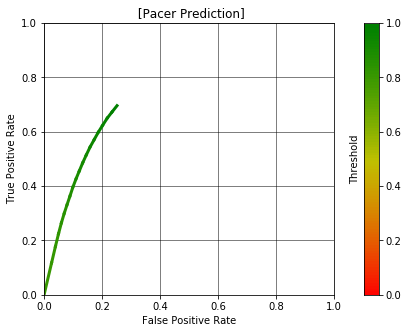

In [59]:
plotColorRoc(pacerRate, vault="")

In [60]:
pTrain = pd.merge(pacerData, trainDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pTest = pd.merge(pacerData, testDF[metaColumns].drop(columns=['Success']), on='ContestId', how='inner').dropna()

In [61]:
pCLFS = EnsembleWithMinAcc(pTrain, RandomForestClassifier, accuracy = .6)
pPreds = avgVal(getEnsPred(pTest, pCLFS))
pEnsembleRates =  getRate(pPreds, 'AvgPred', label='Ensemble of Pacer+Header Prediction')

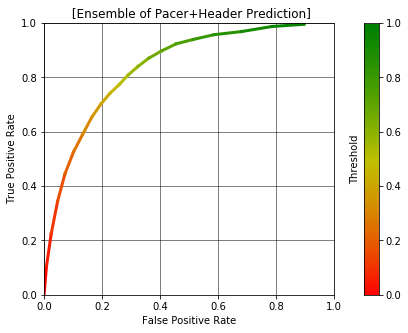

In [62]:
plotColorRoc(pEnsembleRates, vault="")

In [63]:
pmTrain = pd.merge(pacerData, trainDF[list(set(metaColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pmTest = pd.merge(pacerData, testDF[list(set(metaColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
pmTrain = limitVal(pmTrain, ignore=metaColumns, N=1.)
pmTest = limitVal(pmTest, ignore=metaColumns, N=1.)

In [64]:
pmCLFS = EnsembleWithMinAcc(pmTrain, RandomForestClassifier, accuracy = .6)
pmPreds = avgVal(getEnsPred(pmTest, pmCLFS))
pmEnsembleRates =  getRate(pmPreds, 'AvgPred', label='Ensemble of Pacer+Header Prediction')

In [65]:
fpTrain = pd.merge(pacerData, trainDF[list(set(metaColumns+kfColumns+lrColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTest = pd.merge(pacerData, testDF[list(set(metaColumns+kfColumns+lrColumns))].drop(columns=['Success']), on='ContestId', how='inner').dropna()
fpTrain = limitVal(fpTrain, ignore=metaColumns, N=1.)
fpTest = limitVal(fpTest, ignore=metaColumns, N=1.)

In [66]:
fpCLFS = EnsembleWithMinAcc(fpTrain, RandomForestClassifier, accuracy = .6)
fpPreds = avgVal(getEnsPred(fpTest, fpCLFS))
fpEnsembleRates =  getRate(fpPreds, 'AvgPred', label='Ensemble of Pacer+WLS+KF+Header Prediction')

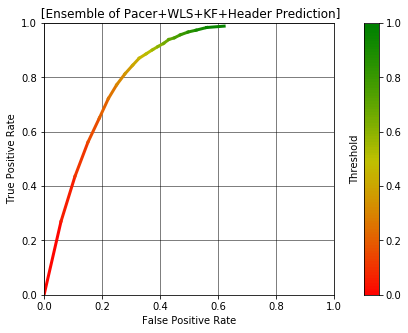

In [67]:
plotColorRoc(fpEnsembleRates, vault="")

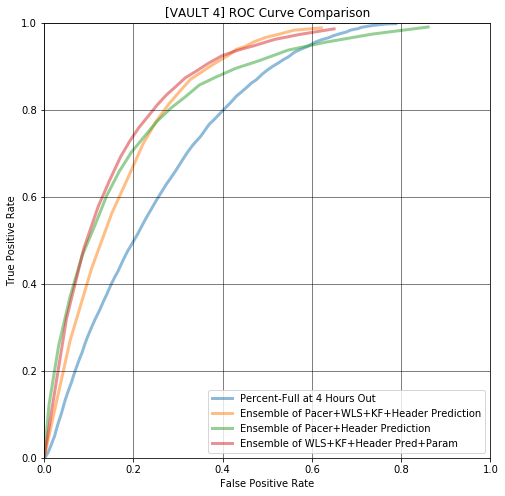

In [68]:
plotRocs([baselineRates, fpEnsembleRates, pmEnsembleRates, fullEnsembleRates])

### Situational Predictions

In [75]:
metaCLFS = EnsembleWithMinAcc(limitVal(metaTrain), RandomForestClassifier, accuracy = .6)

In [76]:
fullCLFS = EnsembleWithMinAcc(limitVal(fullTrain2), RandomForestClassifier, accuracy = .6)

In [77]:
def combinePredictions(testDF, metaCLFs, fullCLFs):
    metaPreds = avgVal(getEnsPred(testDF, metaCLFs))
    metaPreds = metaPreds.rename(columns={'AvgPred':'MetaPred'})[['MetaPred', 'Success']]
    
    fullPreds = avgVal(getEnsPred(testDF, fullCLFs))
    fullPreds = fullPreds.rename(columns={'AvgPred':'FullPred'})[['FullPred']]
    
    merged = pd.merge(fullPreds, metaPreds, on='ContestId', how='outer')
    merged = merged.assign(HasNoPrediction = lambda contest: (contest.index.isin(tooShortIds)).astype(np.int32))
    
    merged = merged.assign(SituationalPrediction = merged.FullPred*(1-merged.HasNoPrediction) + merged.MetaPred*merged.HasNoPrediction)
    return merged

In [78]:
testResults = combinePredictions(limitVal(testDF), metaCLFS, fullCLFS)
testRates =  getRate(testResults, 'SituationalPrediction', label='Situational Predictor')

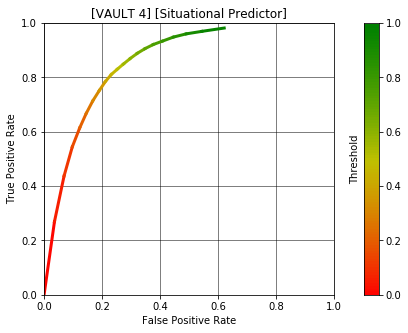

In [79]:
plotColorRoc(testRates)

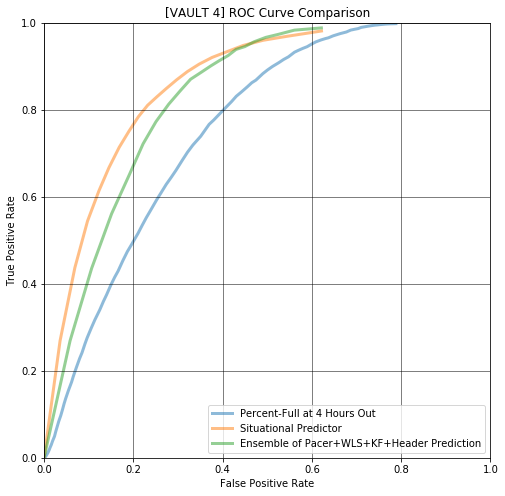

In [80]:
plotRocs([baselineRates, testRates, fpEnsembleRates])